In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

## Policy Gradient Algorithms


The main goal of this TD is helping you understand Policy Gradient (PG) algorithms like REINFORCE, TRPO and PPO. 
You will be provided with some boilerplate code to skip the boring parts, and will need to implement the actual update logic of the algorithms.

The following code is largely taken from [CleanRL](https://github.com/vwxyzjn/cleanrl), which is a good general reference for implementation of RL algorithms. I suggest you do not look at its code before getting something to work at least somewhat well -- but don't hesitate to look at these and other implementations later, to see how the tiny details might differ (sometimes in an impactful way!).

## Environments

In this exercise we will use the [gym](https://github.com/openai/gym) library for the environment. Later, we will try our algorithms on a Unity MLAgents environment.

In [2]:
# Imports
import sys
import abc
from tqdm.notebook import tqdm, trange
import numpy as np
import time

import gym
from gym.wrappers import RecordVideo

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# Detect if CUDA acceleration is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


/home/sauxpa/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")
print(f"gym.__version__ = {gym.__version__}")

python --version = 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
torch.__version__ = 1.7.1
np.__version__ = 1.21.1
gym.__version__ = 0.20.0


## Torch 101

>"The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. 
[...] provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions." 
[PyTorch](https://pytorch.org/docs/stable/index.html)


### Variable types

In [5]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print('zero_torch is of type {:s}'.format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print('\nFloat:\n', zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print('Int:\n', zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print('Bool:\n', zero_torch_bool)

# Reshape
print('\nView new shape...', zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print('\nAlgebraic operations are overloaded:\n', a, '\n+\n', b, '\n=\n', a+b )

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[ 0.2731, -0.0592],
        [ 2.0191, -0.5297],
        [ 1.6174, -0.4504]]) 
+
 tensor([[-0.1912, -0.0562],
        [ 0.7973, -0.2951],
        [-1.3369, -0.5099]]) 
=
 tensor([[ 0.0819, -0.1154],
        [ 2.8164, -0.8247],
        [ 0.2804, -0.9603]])


### Gradient management

In [6]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to 
# handle automatic differentiation (i.e keeping track of the gradient and which 
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training 
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it. 
# However when returning the result of training, do use detach() to save memory 
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=0.1)

# Loss function
print('Initial guess:', theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()
    
    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2
    
    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()
    
    # Run one step of optimisation routine.
    optimizer.step()
    
print('Final estimate:', theta.detach())
print('The final estimate should be close to', y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([0.0919])
Final estimate: tensor([2.0041])
The final estimate should be close to tensor([2.])


## CartPole again

In [7]:
# Create an environment
env = gym.make('CartPole-v0')

In [8]:
obs = env.reset()
print(obs)

[ 0.02800252 -0.02187431 -0.00536191 -0.03012822]


In [9]:
obs, reward, done, info = env.step(0)
print(f"New observation: {obs}")
print(f"Reward: {reward}")
print(f"Episode finished: {done}")
print(f"Extra info: {info}")

New observation: [ 0.02756504 -0.21691896 -0.00596447  0.26085815]
Reward: 1.0
Episode finished: False
Extra info: {}


In [10]:
# Some extra info about the environment
print(f"Observation space: {env.observation_space}")
print(f"Observation space shape: {env.observation_space.shape}")
print(f"Action space: {env.action_space}")

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Observation space shape: (4,)
Action space: Discrete(2)


## Playing a random episode of CartPole

Showing/recording a video with a jupyter notebook is always tricky, the below works with Chrome but might fail or behave weirdly in a different browser.

In [11]:
done = False
state = env.reset()
while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    env.render(mode='rgb_array')
env.close()

## Agent 
Let's implement the Agent class. It represents the policy (actor) $\pi_\theta\colon \mathcal{S} \to \mathcal{A}$, as well as the value estimator (critic) $V_{\theta'}\colon \mathcal{S} \to \mathbb{R}$, where $\theta, \theta'$ are parameters (typically the weights and biases of neural network approximators).

In [12]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, n_input, hidden_size, n_output):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_input, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, n_output)
        )

    def forward(self, x):
        return self.net(x)


class Agent(nn.Module):
    def __init__(self, env: gym.Env):
        super().__init__()
        # Hint: use the fact that the environment is an argument here, to deduce the input and output shapes of the network
        
        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.n
        
        # Note - you can structure your code differently. This is just one of the options.
        self.critic = Net(self.nS, 32, 1)
        self.actor = Net(self.nS, 32, self.nA)

    def get_value(self, x: Tensor) -> Tensor:
        return self.critic(x)

    def get_action(self, x: Tensor, action=None) -> ...:
        # Hint: you might want to return some more properties of the action distribution than just the selected action.
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy()

## Training

Now we're getting into the meat of the algorithm - the training loop.
First let's do some bookkeeping.

In [13]:
# Gym environment name
# ENV_NAME = 'CartPole-v0'
ENV_NAME = 'CartPole-v1'

# Discount factor
GAMMA = 0.99

# Number of epoch to train neural networks
N_EPOCH = 10

# Size of minibatch (sample one minibatch per epoch)
MB_SIZE = 32

# How many steps (environment iterations) per training iteration?
N_STEPS = 500
 
# How many agent updates
N_UPDATES = 50

In [14]:
class TrainMgr(abc.ABC):
    def __init__(self, env_name, device, gamma=0.99):
        self.env_name = env_name
        self.device = device
        self.gamma = gamma
        self.reset()

    def reset(self):
        self.env = gym.make(self.env_name)
        self.agent = Agent(self.env)
        self.actor_optimizer = optim.Adam(self.agent.actor.parameters(), lr=3e-4, eps=1e-5)
        self.critic_optimizer = optim.Adam(self.agent.critic.parameters(), lr=3e-4, eps=1e-5)
        
        self.mean_total_rewards = []
        self.q_10_total_rewards = []
        self.q_90_total_rewards = []

    def generate_rollout(self, num_steps, start_obs, start_done):
        """Play during num_steps, reset episode if the agent reaches the end.
        """
        # Initialize run
        next_obs = start_obs
        next_done = start_done

        # Initialize some storage buffers
        obs = torch.zeros((num_steps,) + self.env.observation_space.shape).to(self.device)
        actions = torch.zeros((num_steps,) + self.env.action_space.shape).to(self.device)
        logprobs = torch.zeros((num_steps,)).to(self.device)
        rewards = torch.zeros((num_steps,)).to(self.device)
        dones = torch.zeros((num_steps,)).to(self.device)

        for step in range(0, num_steps):
            obs[step] = next_obs
            dones[step] = next_done

            # Get the action and everything else necessary from the agent
            with torch.no_grad():
                action, logprob, _ = self.agent.get_action(next_obs)

            # Record some data
            actions[step] = action
            logprobs[step] = logprob

            # Take a step in the environment
            next_obs, reward, done, info = self.env.step(action.cpu().numpy())
            # Record the reward
            rewards[step] = torch.tensor(reward).to(self.device)

            if done:
                next_obs = self.env.reset()

            next_obs, next_done = torch.Tensor(next_obs).to(self.device), torch.Tensor([done]).to(self.device)

        return obs, actions, logprobs, rewards, dones

    def full_episode_rewards(self, rewards, dones):
        """Slice and dice the rollout to get total rewards per episode.
        """
        ep_rewards = []
        current_ret = 0
        for r, d in zip(rewards, dones):
            if d:
                ep_rewards.append(current_ret)
                current_ret = 0
            current_ret += r
        if len(ep_rewards) == 0:
            ep_rewards.append(current_ret)
        return ep_rewards
    
    def render(self):
        done = False
        next_obs = torch.Tensor(self.env.reset()).to(self.device)
        while not done:
            with torch.no_grad():
                action, _, _ = self.agent.get_action(next_obs)
            state, reward, done, info = self.env.step(action.cpu().numpy())
            self.env.render(mode='rgb_array')
        self.env.close()        

    @abc.abstractmethod
    def fit(self):
        pass
    

def plot_xp(algs):
    """Algs is a list of TrainMgr object (or children of it).
    """
    colors = plt.cm.rainbow(np.linspace(0, 1, len(algs)))
    
    with sns.axes_style('darkgrid'):
        fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
        
        for i, alg in enumerate(algs):
            ax.plot(range(1, N_UPDATES + 1), alg.mean_total_rewards, color=colors[i], label=alg.name)
            ax.fill_between(range(1, N_UPDATES + 1), alg.q_10_total_rewards, alg.q_90_total_rewards, color=colors[i], alpha=0.2)

        ax.set_xlabel('Number of updates')
        ax.set_ylabel('Returns')
        ax.legend(loc='lower right', prop={'size': 12})

        plt.tight_layout()
        plt.show()

## REINFORCE

Let $\tau = (s_1, a_1, r_1, \dots, s_{H+1})$ a rollout of the MDP following a policy $\pi_\theta$ and $R_\tau=\sum_{t=1}^H r_t$ the total reward, or *return* of the rollout $\tau$.

The goal of an agent is to maximize 
$$J(\theta) = \mathbb{E}[R_\tau],$$
where the expectation is over the randomness of the MDP (transitions, rewards) and the stochastic policy $\pi_\theta$.

In order to find the parameter $\theta$ (i.e the policy) that maximizes the expected return, it is natural to compute the gradient $\nabla_\theta J$.
The Policy Gradient Theorem states that
$$ \nabla_\theta J(\theta) = \mathbb{E}[R_\tau \nabla_\theta \log \pi_\theta].$$

REINFORCE is a simple algorithm that implements gradient *ascent* on an estimation of $J(\theta)$ sampled from multiple episodes. 

In [15]:
class ReinforceMgr(TrainMgr):
    def __init__(self, env_name, device, gamma=0.99):
        self.name = 'REINFORCE'
        super().__init__(env_name, device, gamma)
    
    def fit(self, n_updates, n_steps, n_epoch, mb_size):
        start_time = time.time()
    
        self.mean_total_rewards = np.zeros(n_updates)
        self.q_10_total_rewards = np.zeros(n_updates)
        self.q_90_total_rewards = np.zeros(n_updates)

        for update in trange(n_updates):
            start_obs = torch.Tensor(self.env.reset()).to(self.device)
            start_done = torch.zeros((1,)).to(self.device)

            # Generate rollout
            obs, actions, logprobs, rewards, dones = self.generate_rollout(n_steps, start_obs, start_done)

            # Compute average total rewards
            ep_rewards = self.full_episode_rewards(rewards, dones)
            self.mean_total_rewards[update] = np.mean(ep_rewards)
            self.q_10_total_rewards[update] = np.quantile(ep_rewards, 0.1)
            self.q_90_total_rewards[update] = np.quantile(ep_rewards, 0.9)

            # Now you need to compute the returns.
            # Remember that the return is defined as the discounted sum of rewards from that step onwards.
            with torch.no_grad():
                last_reward = rewards[-1]
                last_done = dones[-1]
                returns = torch.zeros_like(rewards).to(self.device)
                for t in reversed(range(n_steps)):
                    if t == n_steps - 1:
                        nextnonterminal = 1.0 - last_done
                        next_return = last_reward
                    else:
                        nextnonterminal = 1.0 - dones[t + 1]
                        next_return = returns[t + 1]
                    returns[t] = rewards[t] + self.gamma * nextnonterminal * next_return

            # Flatten the batch
            b_obs = obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = logprobs.reshape(-1)
            b_actions = actions.reshape((-1,) + self.env.action_space.shape)
            b_returns = returns.reshape(-1)

            # Optimizing the policy and value network

            # Your time to shine! Compute the necessary gradients, and apply them to the network.
            # Depending on the algorithm you're implementing, you might want to remove this inner loop
            # and compute them on the entire batch of data. Feel free to modify the code however you see fit.
            b_inds = np.arange(n_steps)

            for epoch in range(n_epoch):
                np.random.shuffle(b_inds)
                for start in range(0, n_steps, mb_size):
                    end = start + mb_size

                    # Minibatch
                    mb_inds = b_inds[start:end]
                    mb_returns = b_returns[mb_inds]

                    _, newlogprob, _ = self.agent.get_action(b_obs[mb_inds], b_actions.long()[mb_inds])

                    # Policy loss
                    loss = -(mb_returns * newlogprob).mean()

                    self.actor_optimizer.zero_grad()
                    loss.backward()
                    self.actor_optimizer.step()

        self.train_time = time.time() - start_time

  0%|          | 0/50 [00:00<?, ?it/s]

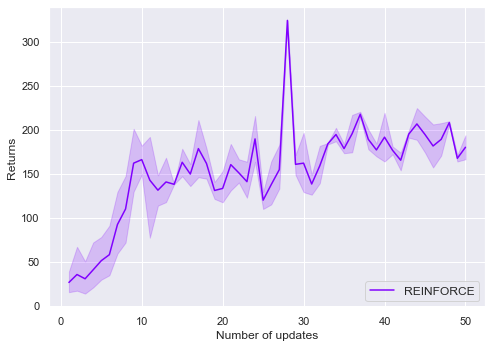

In [16]:
reinforce = ReinforceMgr(ENV_NAME, DEVICE)
reinforce.fit(N_UPDATES, N_STEPS, N_EPOCH, MB_SIZE)
plot_xp([reinforce])

In [17]:
reinforce.render()

## REINFORCE with baseline

A fruitful idea to speed up a stochastic algorithm that estimates an expectation is *variance reduction*.
Indeed, if $R$ is a random variable and $R^1, \dots, R^n$ i.i.d samples of $R$, then (under mild assumptions) $\frac{1}{n}\sum_{i=1}^nR^i \rightarrow \mathbb{E}[R]$ at rate $\sqrt{\frac{Var(R)}{n}}$. 

A standard variance reduction technique is to use a *baseline* variable $B$ such that $\mathbb{E}[B]=0$ and estimate $\mathbb{E}[R-B]$.

1) When is the variance of $R-B$ smaller than the variance of $R$?

In the context of REINFORCE, $R$ is the return of an episode, and we estimate $\mathbb{E}[R\nabla_\theta\log \pi_\theta]$.

2) Explain why $B$ independent of the policy $\pi_\theta$ is a suitable choice of baseline. Suggest one and implement the corresponding REINFORCE with baseline.

In [18]:
class ReinforceBaselineMgr(TrainMgr):
    def __init__(self, env_name, device, gamma=0.99):
        self.name = 'REINFORCE_baseline'
        super().__init__(env_name, device, gamma)
    
    def generate_rollout(self, num_steps, start_obs, start_done):
        """Play during num_steps, reset episode if the agent reaches the end.
        """
        # Initialize run
        next_obs = start_obs
        next_done = start_done

        # Initialize some storage buffers
        obs = torch.zeros((num_steps,) + self.env.observation_space.shape).to(self.device)
        actions = torch.zeros((num_steps,) + self.env.action_space.shape).to(self.device)
        logprobs = torch.zeros((num_steps,)).to(self.device)
        rewards = torch.zeros((num_steps,)).to(self.device)
        dones = torch.zeros((num_steps,)).to(self.device)
        values = torch.zeros((num_steps,)).to(self.device)
        
        for step in range(0, num_steps):
            obs[step] = next_obs
            dones[step] = next_done

            # Get the action and everything else necessary from the agent
            with torch.no_grad():
                action, logprob, _ = self.agent.get_action(next_obs)
                value = self.agent.get_value(next_obs)

            # Record some data
            actions[step] = action
            logprobs[step] = logprob
            values[step] = value.flatten()

            # Take a step in the environment
            next_obs, reward, done, info = self.env.step(action.cpu().numpy())
            # Record the reward
            rewards[step] = torch.tensor(reward).to(self.device)

            if done:
                next_obs = self.env.reset()

            next_obs, next_done = torch.Tensor(next_obs).to(self.device), torch.Tensor([done]).to(self.device)

        return obs, actions, logprobs, rewards, dones, values

    def fit(self, n_updates, n_steps, n_epoch, mb_size):
        start_time = time.time()
    
        self.mean_total_rewards = np.zeros(n_updates)
        self.q_10_total_rewards = np.zeros(n_updates)
        self.q_90_total_rewards = np.zeros(n_updates)

        for update in trange(n_updates):
            start_obs = torch.Tensor(self.env.reset()).to(self.device)
            start_done = torch.zeros((1,)).to(self.device)

            # Generate rollout
            obs, actions, logprobs, rewards, dones, values = self.generate_rollout(n_steps, start_obs, start_done)

            # Compute average total rewards
            ep_rewards = self.full_episode_rewards(rewards, dones)
            self.mean_total_rewards[update] = np.mean(ep_rewards)
            self.q_10_total_rewards[update] = np.quantile(ep_rewards, 0.1)
            self.q_90_total_rewards[update] = np.quantile(ep_rewards, 0.9)

            # Now you need to compute the returns.
            # Remember that the return is defined as the discounted sum of rewards from that step onwards.
            with torch.no_grad():
                next_value = self.agent.get_value(obs[-1]).reshape(1, -1)
                last_reward = rewards[-1]
                last_done = dones[-1]
                returns = torch.zeros_like(rewards).to(self.device)
                for t in reversed(range(n_steps)):
                    if t == n_steps - 1:
                        nextnonterminal = 1.0 - last_done
#                         next_return = last_reward
                        next_return = next_value
                    else:
                        nextnonterminal = 1.0 - dones[t + 1]
                        next_return = returns[t + 1]
                    returns[t] = rewards[t] + self.gamma * nextnonterminal * next_return
                advantages = returns - values

            # Flatten the batch
            b_obs = obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = logprobs.reshape(-1)
            b_actions = actions.reshape((-1,) + self.env.action_space.shape)
            b_returns = returns.reshape(-1)
            b_advantages = advantages.reshape(-1)

            # Optimizing the policy and value network

            # Your time to shine! Compute the necessary gradients, and apply them to the network.
            # Depending on the algorithm you're implementing, you might want to remove this inner loop
            # and compute them on the entire batch of data. Feel free to modify the code however you see fit.
            b_inds = np.arange(n_steps)

            for epoch in range(n_epoch):
                np.random.shuffle(b_inds)
                for start in range(0, n_steps, mb_size):
                    end = start + mb_size

                    # Minibatch
                    mb_inds = b_inds[start:end]

                    _, newlogprob, _ = self.agent.get_action(b_obs[mb_inds], b_actions.long()[mb_inds])
                    newvalue = self.agent.get_value(b_obs[mb_inds])

                    mb_advantages = b_advantages[mb_inds]
                    mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    # Policy loss
                    pg_loss = -(mb_advantages * newlogprob).mean()

#                     mb_returns = b_returns[mb_inds]        
#                     mb_returns = (mb_returns - mb_returns.mean()) / (mb_returns.std() + 1e-8)

#                     # Policy loss
#                     pg_loss = -(mb_returns * newlogprob).mean()

                    # Value loss
                    newvalue = newvalue.view(-1)
                    v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    self.actor_optimizer.zero_grad()
                    pg_loss.backward()
                    self.actor_optimizer.step()
                    
                    self.critic_optimizer.zero_grad()
                    v_loss.backward()
                    self.critic_optimizer.step()

        self.train_time = time.time() - start_time

  0%|          | 0/50 [00:00<?, ?it/s]

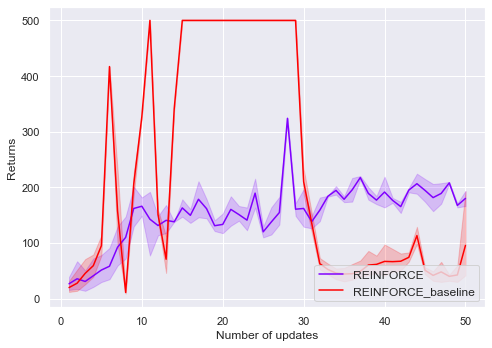

In [19]:
reinforce_b = ReinforceBaselineMgr(ENV_NAME, DEVICE)
reinforce_b.fit(N_UPDATES, N_STEPS, N_EPOCH, MB_SIZE)
plot_xp([reinforce, reinforce_b])

## PPO

In [20]:
class PPOMgr(TrainMgr):
    def __init__(self, env_name, device, gamma=0.99, clip_coeff=0.2):
        self.name = 'PPO'
        self.clip_coeff = clip_coeff
        super().__init__(env_name, device, gamma)
    
    def generate_rollout(self, num_steps, start_obs, start_done):
        """Play during num_steps, reset episode if the agent reaches the end.
        """
        # Initialize run
        next_obs = start_obs
        next_done = start_done

        # Initialize some storage buffers
        obs = torch.zeros((num_steps,) + self.env.observation_space.shape).to(self.device)
        actions = torch.zeros((num_steps,) + self.env.action_space.shape).to(self.device)
        logprobs = torch.zeros((num_steps,)).to(self.device)
        rewards = torch.zeros((num_steps,)).to(self.device)
        dones = torch.zeros((num_steps,)).to(self.device)
        values = torch.zeros((num_steps,)).to(self.device)
        
        for step in range(0, num_steps):
            obs[step] = next_obs
            dones[step] = next_done

            # Get the action and everything else necessary from the agent
            with torch.no_grad():
                action, logprob, _ = self.agent.get_action(next_obs)
                value = self.agent.get_value(next_obs)

            # Record some data
            actions[step] = action
            logprobs[step] = logprob
            values[step] = value.flatten()

            # Take a step in the environment
            next_obs, reward, done, info = self.env.step(action.cpu().numpy())
            # Record the reward
            rewards[step] = torch.tensor(reward).to(self.device)

            if done:
                next_obs = self.env.reset()

            next_obs, next_done = torch.Tensor(next_obs).to(self.device), torch.Tensor([done]).to(self.device)

        return obs, actions, logprobs, rewards, dones, values

    def fit(self, n_updates, n_steps, n_epoch, mb_size):
        start_time = time.time()
    
        self.mean_total_rewards = np.zeros(n_updates)
        self.q_10_total_rewards = np.zeros(n_updates)
        self.q_90_total_rewards = np.zeros(n_updates)

        for update in trange(n_updates):
            start_obs = torch.Tensor(self.env.reset()).to(self.device)
            start_done = torch.zeros((1,)).to(self.device)

            # Generate rollout
            obs, actions, logprobs, rewards, dones, values = self.generate_rollout(n_steps, start_obs, start_done)

            # Compute average total rewards
            ep_rewards = self.full_episode_rewards(rewards, dones)
            self.mean_total_rewards[update] = np.mean(ep_rewards)
            self.q_10_total_rewards[update] = np.quantile(ep_rewards, 0.1)
            self.q_90_total_rewards[update] = np.quantile(ep_rewards, 0.9)

            # Now you need to compute the returns.
            # Remember that the return is defined as the discounted sum of rewards from that step onwards.
            with torch.no_grad():
                next_value = self.agent.get_value(obs[-1]).reshape(1, -1)
                last_done = dones[-1]
                returns = torch.zeros_like(rewards).to(self.device)
                for t in reversed(range(n_steps)):
                    if t == n_steps - 1:
                        nextnonterminal = 1.0 - last_done
                        next_return = next_value
                    else:
                        nextnonterminal = 1.0 - dones[t + 1]
                        next_return = returns[t + 1]
                    returns[t] = rewards[t] + self.gamma * nextnonterminal * next_return
                advantages = returns - values

            # Flatten the batch
            b_obs = obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = logprobs.reshape(-1)
            b_actions = actions.reshape((-1,) + self.env.action_space.shape)
            b_returns = returns.reshape(-1)
            b_advantages = advantages.reshape(-1)

            # Optimizing the policy and value network

            # Your time to shine! Compute the necessary gradients, and apply them to the network.
            # Depending on the algorithm you're implementing, you might want to remove this inner loop
            # and compute them on the entire batch of data. Feel free to modify the code however you see fit.
            b_inds = np.arange(n_steps)

            for epoch in range(n_epoch):
                np.random.shuffle(b_inds)
                for start in range(0, n_steps, mb_size):
                    end = start + mb_size

                    # Minibatch
                    mb_inds = b_inds[start:end]

                    _, newlogprob, entropy = self.agent.get_action(b_obs[mb_inds], b_actions.long()[mb_inds])
                    newvalue = self.agent.get_value(b_obs[mb_inds])

                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    mb_advantages = b_advantages[mb_inds]
                    mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    # Policy loss
                    pg_loss1 = -mb_advantages * ratio
                    pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - self.clip_coeff, 1 + self.clip_coeff)
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    # Value loss
                    newvalue = newvalue.view(-1)

                    v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    self.actor_optimizer.zero_grad()
                    pg_loss.backward()
                    self.actor_optimizer.step()
                    
                    self.critic_optimizer.zero_grad()
                    v_loss.backward()
                    self.critic_optimizer.step()

        self.train_time = time.time() - start_time

  0%|          | 0/50 [00:00<?, ?it/s]

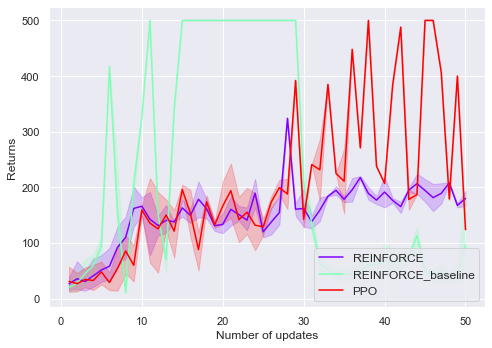

In [21]:
ppo = PPOMgr(ENV_NAME, DEVICE)
ppo.fit(N_UPDATES, N_STEPS, N_EPOCH, MB_SIZE)
plot_xp([reinforce, reinforce_b, ppo])

# Bonus: Unity ML-Agents

In [ ]:
from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToGymWrapper
import os


def make_unity_environment():
    # Create an environment
    if os.name == 'posix':
        unity_env = UnityEnvironment('./3DBallSingleAgent/3DBallSingleAgent_unix/3DBallSingleAgent.x86_64')
    elif os.name == 'nt':
        unity_env = UnityEnvironment('./3DBallSingleAgent/3DBallSingleAgent_windows')
    else:
        raise ValueError('Sorry, your OS is not supported :(')
    return UnityToGymWrapper(unity_env, 0)

In [ ]:
env = make_unity_environment()
# Do some testing
obs = env.reset()
print(obs)

action = env.action_space.sample()
obs, reward, done, info = env.step(action)
env.close()

print(f"New observation: {obs}")
print(f"Reward: {reward}")
print(f"Episode finished: {done}")
print(f"Extra info: {info}")

print(f"Observation space: {env.observation_space}")
print(f"Observation space shape: {env.observation_space.shape}")
print(f"Action space: {env.action_space}")
print(f"Action space shape: {env.action_space.shape}")

## Agent

In [ ]:
from torch.distributions.beta import Beta

class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, n_input, hidden_size, n_output):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_input, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, n_output)
        )

    def forward(self, x):
        return self.net(x)


# class Agent(nn.Module):
#     def __init__(self, env: gym.Env):
#         super().__init__()
#         # Hint: use the fact that the environment is an argument here, to deduce the input and output shapes of the network

#         self.nS = env.observation_space.shape[0]
#         self.nA = env.action_space.shape[0]

#         self.sigma = 10.0

#         # Note - you can structure your code differently. This is just one of the options.
#         self.critic = Net(self.nS, 32, 1)
#         self.actor = Net(self.nS, 32, self.nA)

#     def get_value(self, x: Tensor) -> Tensor:
#         return self.critic(x)

#     def get_action(self, x: Tensor, action=None) -> ...:
#         # Hint: you might want to return some more properties of the action distribution than just the selected action.
#         mu = self.actor(x)
#         probs_0 = Beta(self.sigma * mu[0], self.sigma * (1 - mu[0]))
#         probs_1 = Beta(self.sigma * mu[1], self.sigma * (1 - mu[1]))
#         if action is None:
#             action_0 = probs_0.sample()
#             action_1 = probs_1.sample()
#             action = torch.cat([action_0.reshape(1), action_1.reshape(1)])
#         log_probs = probs_0.log_prob(action[0]) + probs_0.log_prob(action[1])

#         return action, log_probs, None

# from torch.distributions.multinomial import Multinomial

# class Agent(nn.Module):
#     def __init__(self, env: gym.Env):
#         super().__init__()
#         # Hint: use the fact that the environment is an argument here, to deduce the input and output shapes of the network

#         self.nS = env.observation_space.shape[0]
#         self.nA = 4 * 4

#         eps = 1e-4
#         self.discretized_A = torch.linspace(-1 + eps, 1 - eps, self.nA)
#         # Note - you can structure your code differently. This is just one of the options.
#         self.critic = Net(self.nS, 32, 1)
#         self.actor = Net(self.nS, 32, self.nA)

#     def get_value(self, x: Tensor) -> Tensor:
#         return self.critic(x)

#     def get_action(self, x: Tensor, action=None) -> ...:
#         # Hint: you might want to return some more properties of the action distribution than just the selected action.
#         logits = self.actor(x)
#         probs = Multinomial(logits=logits)
#         if action is None:
#             action_01 = torch.argmax(probs.sample())
#             action_0 = self.discretized_A[action_01 % 4]
#             action_1 = self.discretized_A[action_01 // 4]
#             action = torch.cat([action_0.reshape(1), action_1.reshape(1)])
#         log_probs = probs.log_prob(4 * action[1] + action[0])
#         return action, log_probs, _

from torch.distributions.multivariate_normal import MultivariateNormal

class Agent(nn.Module):
    def __init__(self, env: gym.Env):
        super().__init__()
        # Hint: use the fact that the environment is an argument here, to deduce the input and output shapes of the network

        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.shape[0]

        self.sigma = 0.1

        # Note - you can structure your code differently. This is just one of the options.
        self.critic = Net(self.nS, 32, 1)
        self.actor = Net(self.nS, 32, self.nA)

    def get_value(self, x: Tensor) -> Tensor:
        return self.critic(x)

    def get_action(self, x: Tensor, action=None) -> ...:
        # Hint: you might want to return some more properties of the action distribution than just the selected action.
        mu = self.actor(x)
        
        probs = MultivariateNormal(mu, self.sigma * torch.eye(2))

        if action is None:
            action = torch.clamp(probs.sample(), -1 + 1e-4, 1 - 1e-4)
        log_probs = probs.log_prob(action)

        return action, log_probs, None

In [ ]:
# Discount factor
GAMMA = 0.99

# Number of epoch to train neural networks
N_EPOCH = 10

# Size of minibatch (sample one minibatch per epoch)
MB_SIZE = 32

# How many steps (environment iterations) per training iteration?
N_STEPS = 100
 
# How many agent updates
N_UPDATES = 50

In [ ]:
class PPOM3DBallMgr():
    def __init__(self, env_name, device, gamma=0.99, clip_coeff=0.2):
        self.name = 'PPO3DBall'
        self.device = device
        self.gamma = gamma
        self.clip_coeff = clip_coeff
        self.reset()
        
    def reset(self):
        self.env = make_unity_environment()
        self.agent = Agent(self.env)
        self.actor_optimizer = optim.Adam(self.agent.actor.parameters(), lr=3e-4, eps=1e-5)
        self.critic_optimizer = optim.Adam(self.agent.critic.parameters(), lr=3e-4, eps=1e-5)
        
        self.mean_total_rewards = []
        self.q_10_total_rewards = []
        self.q_90_total_rewards = []

    def generate_rollout(self, num_steps, start_obs, start_done):
        """Play during num_steps, reset episode if the agent reaches the end.
        """
        # Initialize run
        next_obs = start_obs
        next_done = start_done

        # Initialize some storage buffers
        obs = torch.zeros((num_steps,) + self.env.observation_space.shape).to(self.device)
        actions = torch.zeros((num_steps,) + self.env.action_space.shape).to(self.device)
        logprobs = torch.zeros((num_steps,)).to(self.device)
        rewards = torch.zeros((num_steps,)).to(self.device)
        dones = torch.zeros((num_steps,)).to(self.device)
        values = torch.zeros((num_steps,)).to(self.device)
        
        for step in range(0, num_steps):
            obs[step] = next_obs
            dones[step] = next_done

            # Get the action and everything else necessary from the agent
            with torch.no_grad():
                action, logprob, _ = self.agent.get_action(next_obs)
                value = self.agent.get_value(next_obs)

            # Record some data
            actions[step] = action
            logprobs[step] = logprob
            values[step] = value.flatten()

            # Take a step in the environment
            next_obs, reward, done, info = self.env.step(action.cpu().numpy())
            # Record the reward
            rewards[step] = torch.tensor(reward).to(self.device)

            if done:
                next_obs = self.env.reset()

            next_obs, next_done = torch.Tensor(next_obs).to(self.device), torch.Tensor([done]).to(self.device)

        return obs, actions, logprobs, rewards, dones, values

    def full_episode_rewards(self, rewards, dones):
        """Slice and dice the rollout to get total rewards per episode.
        """
        ep_rewards = []
        current_ret = 0
        for r, d in zip(rewards, dones):
            if d:
                ep_rewards.append(current_ret)
                current_ret = 0
            current_ret += r
        if len(ep_rewards) == 0:
            ep_rewards.append(current_ret)
        return ep_rewards

    def fit(self, n_updates, n_steps, n_epoch, mb_size):
        start_time = time.time()
    
        self.mean_total_rewards = np.zeros(n_updates)
        self.q_10_total_rewards = np.zeros(n_updates)
        self.q_90_total_rewards = np.zeros(n_updates)

        for update in trange(n_updates):
            start_obs = torch.Tensor(self.env.reset()).to(self.device)
            start_done = torch.zeros((1,)).to(self.device)

            # Generate rollout
            obs, actions, logprobs, rewards, dones, values = self.generate_rollout(n_steps, start_obs, start_done)

            # Compute average total rewards
            ep_rewards = self.full_episode_rewards(rewards, dones)
            self.mean_total_rewards[update] = np.mean(ep_rewards)
            self.q_10_total_rewards[update] = np.quantile(ep_rewards, 0.1)
            self.q_90_total_rewards[update] = np.quantile(ep_rewards, 0.9)

            # Now you need to compute the returns.
            # Remember that the return is defined as the discounted sum of rewards from that step onwards.
            with torch.no_grad():
                next_value = self.agent.get_value(obs[-1]).reshape(1, -1)
                last_done = dones[-1]
                returns = torch.zeros_like(rewards).to(self.device)
                for t in reversed(range(n_steps)):
                    if t == n_steps - 1:
                        nextnonterminal = 1.0 - last_done
                        next_return = next_value
                    else:
                        nextnonterminal = 1.0 - dones[t + 1]
                        next_return = returns[t + 1]
                    returns[t] = rewards[t] + self.gamma * nextnonterminal * next_return
                advantages = returns - values

            # Flatten the batch
            b_obs = obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = logprobs.reshape(-1)
            b_actions = actions.reshape((-1,) + self.env.action_space.shape)
            b_returns = returns.reshape(-1)
            b_advantages = advantages.reshape(-1)

            # Optimizing the policy and value network

            # Your time to shine! Compute the necessary gradients, and apply them to the network.
            # Depending on the algorithm you're implementing, you might want to remove this inner loop
            # and compute them on the entire batch of data. Feel free to modify the code however you see fit.
            b_inds = np.arange(n_steps)

            for epoch in range(n_epoch):
                np.random.shuffle(b_inds)
                for start in range(0, n_steps, mb_size):
                    end = start + mb_size

                    # Minibatch
                    mb_inds = b_inds[start:end]

                    pg_loss = torch.zeros((1,))
                    entropy_loss = torch.zeros((1,))
                    
                    newvalue = self.agent.get_value(b_obs[mb_inds])
                    newvalue = newvalue.view(-1)

                    # Value loss
                    v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    mb_advantages = b_advantages[mb_inds]
                    mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

                    for i, mb_ind in enumerate(mb_inds):
                        _, newlogprob, _ = self.agent.get_action(b_obs[mb_ind], b_actions[mb_ind])

                        logratio = newlogprob - b_logprobs[mb_ind]
                        ratio = logratio.exp()
    
                        # Policy loss
                        pg_loss1 = -mb_advantages[i] * ratio
                        pg_loss2 = -mb_advantages[i] * torch.clamp(ratio, 1 - self.clip_coeff, 1 + self.clip_coeff)
                        pg_loss += torch.max(pg_loss1, pg_loss2).mean()
                    
                    self.actor_optimizer.zero_grad()
                    pg_loss.backward()
                    self.actor_optimizer.step()
                    
                    self.critic_optimizer.zero_grad()
                    v_loss.backward()
                    self.critic_optimizer.step()

        self.train_time = time.time() - start_time

In [ ]:
ppo_unity = PPOM3DBallMgr(ENV_NAME, DEVICE)
ppo_unity.fit(N_UPDATES, N_STEPS, N_EPOCH, MB_SIZE)

In [ ]:
plot_xp([ppo_unity])

In [ ]:
ppo_unity.env.close()